In [1]:
import sys
sys.path.append("../ChartSeer/gvae")

from data_utils import test_vaemodel, extract_rules, generate_datasets, test_visvae, visualize_embedding
import numpy as np
import glob
import json

/home/wai/ChartProcessing/ChartSeer/gvae/env/lib/python3.7/site-packages/scipy/__init__.py:149: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.4
  UserWarning)
Using TensorFlow backend.


In [2]:
# ## 1. build the CFG rules file
# extract_rules('../ChartSeer/sourcedata/vegaspecs-processed.txt', '../ChartSeer/gvae/trainingdata/rules-cfg.txt')

# ## 2. generate the traning and testing datasets
# generate_datasets('../ChartSeer/sourcedata/vegaspecs-processed.txt', '../ChartSeer/gvae/trainingdata/rules-cfg.txt', '../ChartSeer/gvae/trainingdata/')

# ## 3. train the model: see train.py
# # e.g., python train.py --hidden 256 --dense 256 --conv1 8 3 --conv3 8 3 --conv3 8 3 --latent 20

# ## 4. test the model performance
# test_vaemodel('../ChartSeer/gvae/trainingdata/rules-cfg.txt', '../ChartSeer/gvae/trained/vae_H256_D256_C444_333_L20_B200.hdf5', '../ChartSeer/gvae/trainingdata/test.h5')

model hyper parameters:{'hidden': 256, 'dense': 256, 'conv1': (4, 3), 'conv2': (4, 3), 'conv3': (4, 3)}
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 20, 53)       0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 18, 4)        640         input_7[0][0]                    
__________________________________________________________________________________________________
batch_1 (BatchNormalization)    (None, 18, 4)        16          conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 16, 4)        52          batch_1[0][0]         

/home/wai/ChartProcessing/ChartSeer/gvae/env/lib/python3.7/site-packages/matplotlib/collections.py:1120: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


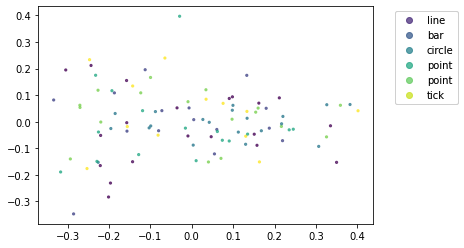

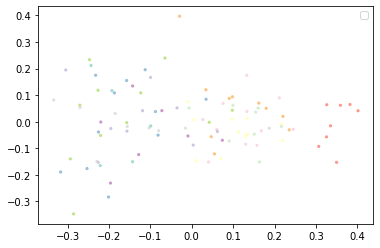

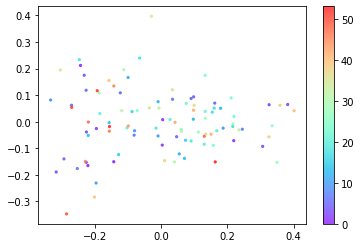

In [9]:
# check if the model works properly
inputspec = []
with open('../ChartSeer/sourcedataold/vegaspecs-processed.txt', 'r') as inputs:
    for line in inputs:
        line = line.strip()
        inputspec.append(line)
inputspec = inputspec[0:100]  # select 5 charts in the input to check the model output
outputspec, z = test_visvae(inputspec, '../ChartSeer/gvae/trainingdataold/rules-cfg.txt', '../ChartSeer/gvae/trainedold/vae_H256_D256_C444_333_L2_B200.hdf5')
with open('../ChartSeer/gvae/results.json', 'w') as outputs:
    outputs.write('{"input": [' + ','.join(inputspec) + '],')
    outputs.write('"output": [' + ','.join(outputspec) + ']}')

# visualize the embedding space
np.save('embeddings.npy', z)
visualize_embedding('embeddings.npy', inputspec, './')

In [16]:
inputspec = []
for filename in glob.glob("spec-v4/*.json"):
#     print(filename)
    with open(filename, "r") as f:
        spec = json.load(f)
#     del spec["data"]
#     del spec["$schema"]
#     if "description" in spec:
#         del spec["description"]
    specString = json.dumps(spec)
    inputspec.append(specString)
with open("vegaspec-raw.txt", "w") as f:
    f.write("\n".join(inputspec))
# inputspec[:4]

In [17]:
cache = []

def getfirstnotempty(arr, targetattr):
    if type(targetattr) is dict:
#         print("dict", targetattr)
        return None
    notempty = True
    for a in arr:
        notempty = True
        if a[targetattr] is None:
            notempty = False
        if notempty:
            return a
    return None
    
def is_number(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

def findfieldtype(obj, data_copy):
    if isinstance(obj, dict):
        if "field" in obj:
#             print("field", obj["field"])
            # HACK: hardcode some aggregated field or field created in runtime
            if "type" in obj and obj["type"] in ["quantitative"]:
#                 print("int")
                obj["field"] = "int"
                return
            if obj["field"] in ["value", "density", "age", "Measurement", "bin_IMDB_Rating", "bin_IMDB_Rating_end", "signed_people", "v1", "v2", "temp_range", "mean_acc", "bin_Horsepwoer", "bin_Horsepwoer_end", "digit", "decade", "binned rating", "binned rating_end", "order", "siteOrder", "x2", "y2"]:
#                 print("int")
                obj["field"] = "int"
                return
            elif obj["field"] in ["gender", "OriginInitial", "month", "url", "ranked_director"]:
#                 print("string")
                obj["field"] = "string"
                return
            elif "type" in obj and obj["type"] in ["geojson"]:
                obj["field"] = "geo"
                return
            
            sample_data = getfirstnotempty(data_copy, obj["field"])
            if sample_data is not None:
                if isinstance(sample_data[obj["field"]], str):
#                     print("string")
                    obj["field"] = "string"
                elif is_number(sample_data[obj["field"]]):
#                     print("int")
                    obj["field"] = "int"
        for key in obj:
            findfieldtype(obj[key], data_copy) 

In [23]:
inputspec = []
inputspecmap = {}
for filename in glob.glob("spec-v4/*.json"):
#     print(filename)
    with open(filename, "r") as f:
        spec = json.load(f)
    
    del spec["$schema"]
    if "description" in spec:
        del spec["description"]
    if "width" in spec:
        del spec["width"]
    if "height" in spec:
        del spec["height"]
    if "params" in spec:
        del spec["params"]
    if "name" in spec:
        del spec["name"]
    
    data_copy = spec["data"]["values"]
    del spec["data"]
    if "transform" in spec:
        del spec["transform"]
    
    findfieldtype(spec,data_copy)
    
    specString = json.dumps(spec)
    inputspec.append(specString)
    inputspecmap[filename] = specString
with open("vegaspec-preprocessed.txt", "w") as f:
    f.write("\n".join(inputspec))
# inputspec[:4]
len(inputspec)

341

max len: 47
{'root -> encoding "+" mark': 159, 'encoding -> tooltip "+" x "+" y': 5, 'tooltip -> aggregate "+" field': 1, 'aggregate -> "mean"': 30, 'field -> "int"': 445, 'x -> field "+" scale "+" type': 25, 'scale -> zero': 34, 'zero -> "False"': 34, 'type -> "quantitative"': 282, 'y -> field "+" type': 100, 'field -> "string"': 235, 'type -> "nominal"': 77, 'mark -> "boxplot"': 7, 'root -> config "+" encoding "+" mark': 16, 'config -> signals': 1, 'signals -> "[{\'name\': \'xLabelAngle\', \'value\': 0, \'bind\': {\'input\': \'range\', \'min\': -360, \'max\': 360}}, {\'name\': \'yLabelAngle\', \'value\': 0, \'bind\': {\'input\': \'range\', \'min\': -360, \'max\': 360}}]"': 1, 'encoding -> size "+" x "+" y': 17, 'size -> aggregate "+" field "+" type': 2, 'aggregate -> "sum"': 38, 'x -> axis "+" field "+" timeUnit "+" type': 1, 'axis -> labelAngle "+" orient': 2, 'labelAngle -> signal': 2, 'signal -> "xLabelAngle"': 1, 'orient -> "top"': 3, 'timeUnit -> "hours"': 3, 'type -> "ordinal"'

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 20, 53)       0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 18, 4)        640         input_15[0][0]                   
__________________________________________________________________________________________________
batch_1 (BatchNormalization)    (None, 18, 4)        16          conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 16, 4)        52          batch_1[0][0]                    
___________________________________________________________________________________________

/home/wai/ChartProcessing/ChartSeer/gvae/env/lib/python3.7/site-packages/matplotlib/collections.py:1120: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


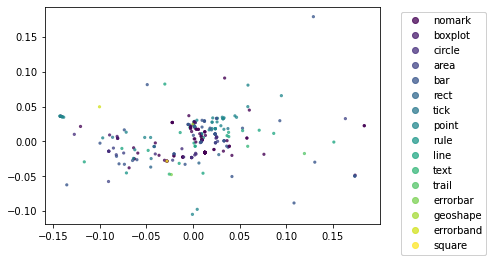

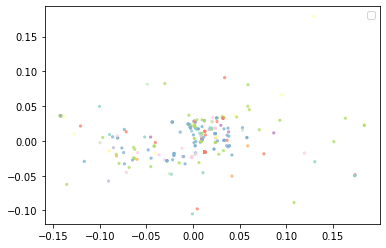

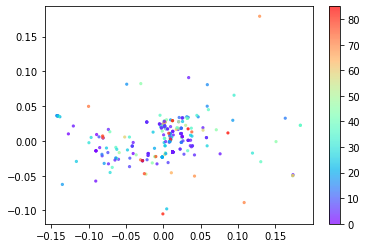

In [24]:
# check if the model works properly
# inputspec = []
# with open('../ChartSeer/sourcedata/vegaspecs-processed.txt', 'r') as inputs:
#     for line in inputs:
#         line = line.strip()
#         inputspec.append(line)
# inputspec = inputspec[0:5]  # select 5 charts in the input to check the model output
# inputspec


## 1. build the CFG rules file
extract_rules("vegaspec-preprocessed.txt", 'rules-cfg.txt')

outputspec, z = test_visvae(inputspec, '../ChartSeer/gvae/trainingdataold/rules-cfg.txt', '../ChartSeer/gvae/trainedold/vae_H256_D256_C444_333_L2_B200.hdf5')
with open('results.json', 'w') as outputs:
    outputs.write('{"input": [' + ','.join(inputspec) + '],')
    outputs.write('"output": [' + ','.join(outputspec) + ']}')
    
# print(z)

# visualize the embedding space
np.save('embeddings.npy', z)
visualize_embedding('embeddings.npy', inputspec, './')

# print(inputspec[0])
# print(outputspec[0])

In [25]:
outputspec

['{"encoding": {"size": {"field": "num", "type": "nominal"}, "x": {"bin": true, "field": "num", "type": "nominal"}, "y": {"bin": true, "field": "num", "type": "nominal"}}, "mark": "circle"}',
 '{"encoding": {"color": {"bin": true, "field": "num", "type": "temporal"}, "detail": {"field": "num", "timeUnit": "year", "type": "temporal"}, "x": {"field": "num", "timeUnit": "year", "type": "temporal"}, "y": {"aggregate": "count", "field": "num", "type": "temporal"}}, "mark": "circle"}',
 '{"encoding": {"size": {"field": "str", "timeUnit": "year", "type": "ordinal"}, "x": {"aggregate": "mean", "field": "str", "type": "ordinal"}, "y": {"bin": true, "field": "str", "type": "ordinal"}}, "mark": "point"}',
 '{"encoding": {"color": {"field": "str", "timeUnit": "month", "type": "quantitative"}, "detail": {"field": "str", "type": "quantitative"}, "x": {"aggregate": "mean", "field": "str", "type": "quantitative"}, "y": {"field": "str", "timeUnit": "month", "type": "quantitative"}}, "mark": "circle"}',

In [26]:
z = np.load('embeddings.npy')

In [27]:
z.shape

(341, 2)

In [28]:
len(inputspec)

341

In [31]:
i = 0
for key in inputspecmap:
    np.save(f'embeddings/{key}.npy', z[i])
    i+=1